# Augmented Data Comparison

In this notebook, different ways to compare the quality of augmented time series are explored.

## 0 Imports and static variables

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch

# own classes
from sklearn.preprocessing import MinMaxScaler

In [23]:
real = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
A = np.array([1, 2, 3, 4, 5, 6, 8, 9, 10, 12])
B = np.array([1, 2.1, 3.1, 4.1, 5.1, 6, 7, 8, 9, 10])

# scale
scaler = MinMaxScaler(feature_range=(0, 1))
real_scaled = scaler.fit_transform(real.reshape(-1, 1))
A_scaled = scaler.fit_transform(A.reshape(-1, 1))
B_scaled = scaler.fit_transform(B.reshape(-1, 1))

loss_MSE = torch.nn.MSELoss()
loss_MAE = torch.nn.L1Loss()

MSE_A = loss_MSE(torch.tensor(real_scaled, dtype=torch.float32), torch.tensor(A_scaled, dtype=torch.float32))
MAE_A = loss_MAE(torch.tensor(real, dtype=torch.float32), torch.tensor(A, dtype=torch.float32))
MSE_B = loss_MSE(torch.tensor(real_scaled, dtype=torch.float32), torch.tensor(B_scaled, dtype=torch.float32))
MAE_B = loss_MAE(torch.tensor(real, dtype=torch.float32), torch.tensor(B, dtype=torch.float32))

print(f'MSE_A: {MSE_A}\n')
print(f'MAE_A: {MAE_A}\n')
print(f'MSE_B: {MSE_B}\n')
print(f'MAE_B: {MAE_B}\n')

MSE_A: 0.0030915215611457825

MAE_A: 0.5

MSE_B: 4.9382710130885243e-05

MAE_B: 0.039999961853027344



In [11]:
DATA_FOLDER = Path("./data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 1 Loading data

In [13]:
aapl = load_time_series(REAL_DATA_FOLDER / "AAPL_10_24_real.csv")
aapl.head()

NameError: name 'load_time_series' is not defined

## 2 Plot Data

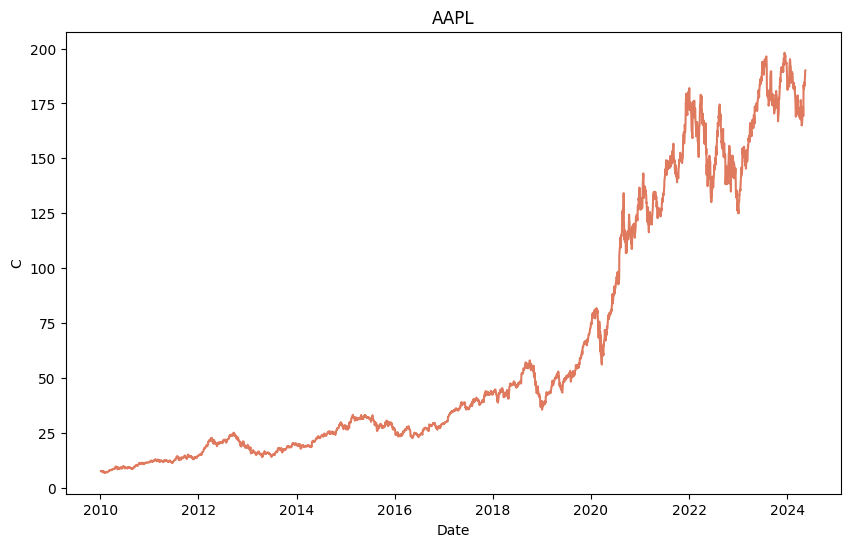

In [ ]:
plot_time_series_attribute(df=aapl, title="AAPL")

In [ ]:
# get only data between 2020-2024
aapl_22_23 = slice_years(df=aapl, years=["2022", "2023"])

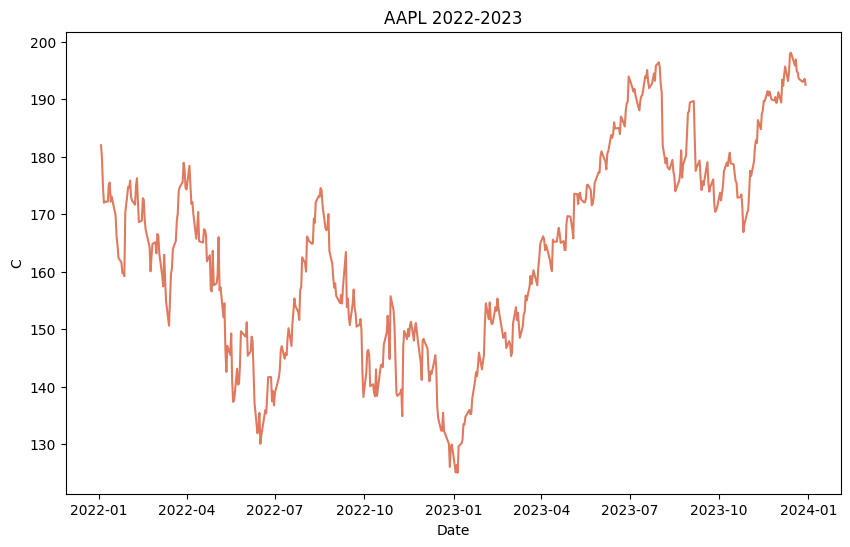

In [ ]:
plot_time_series_attribute(aapl_22_23, "AAPL 2022-2023")

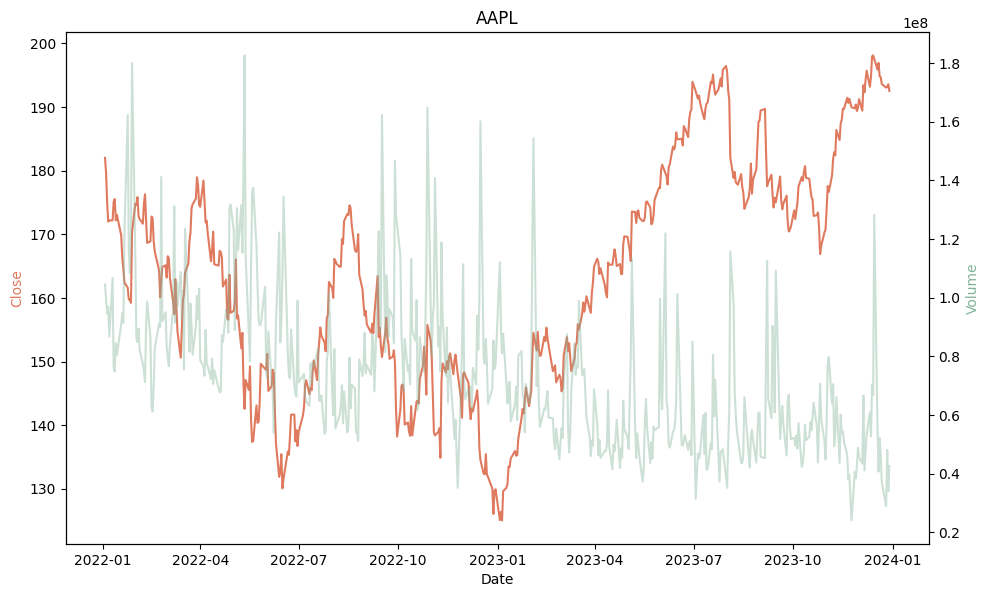

In [ ]:
plot_multiple_time_series_attributes(aapl_22_23, "AAPL")

## 3 Brownian Motion

In [ ]:
aapl_syn = brownian_motion(aapl_22_23, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
aapl_syn.head()

Augmenting the following columns with brownian motion: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']...


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,177.830002,182.880005,177.710007,182.009995,179.481094,1.044879e+08
1,2022-01-04,172.620023,180.388536,176.211397,193.085058,172.600136,0.000000e+00
2,2022-01-05,167.867580,176.796036,179.046459,196.184902,188.092348,4.537602e+14
3,2022-01-06,171.495009,174.516889,179.089305,187.578594,195.036392,9.066193e+14
4,2022-01-07,173.196107,177.556243,175.616598,191.393298,191.480458,1.432839e+15


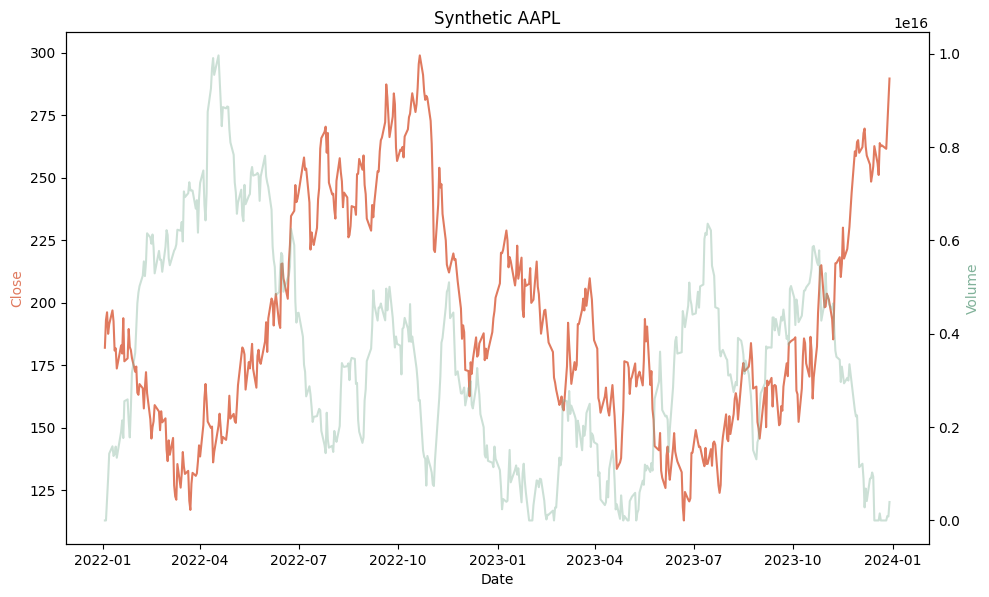

In [ ]:
plot_multiple_time_series_attributes(aapl_syn, title="Synthetic AAPL")

In [ ]:
aapl_syn.to_csv(SYNTHETIC_DATA_FOLDER / 'AAPL_22_23_syn.csv', index=False)

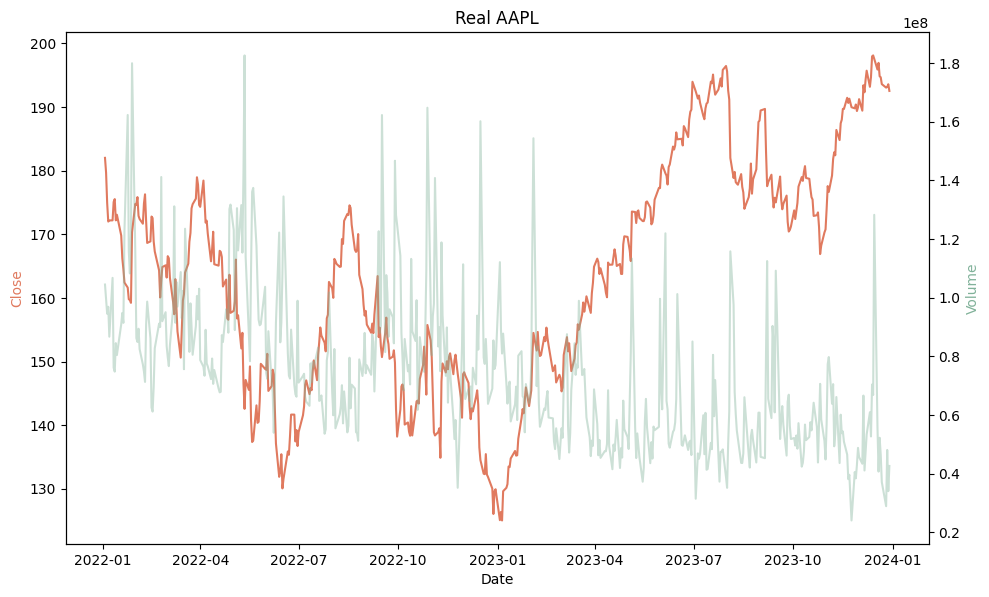

In [ ]:
plot_multiple_time_series_attributes(aapl_22_23, title="Real AAPL")